## **CNN_LSTM Model Hyperparmeter Tuning**
---
From the previous input variation tuning, it was observed that with the base model, the lowest MSE was achieved when we fed ***four 150 * 150*** images to the network and predicted the 5th image. Using this input configuration, this notebook deals with the various hyperparameters of the network. Each Local Feature Learning Block (LFLB) has the same structure of layers i.e. a Conv2D layer followed by BN, then a Conv2D + BN + Dropout layer. This is followed by an LSTM network. The output layer is a Dense layer with 22500 units regenerating the 150 * 150 image.

---
Hyperparameters used: 
- For every LFLB
  - pool_size for MaxPool layer
  - dropout probability
- For the LSTM network
  - number of units
- For dense layer
  - activation
- For network training
  - number of epochs
  - optimizer

---
Organizing the Data: 
- Input images to be present inside the ***INSAT3D_TIR1_PNG*** folder either inside the Drive or on local
- Images to be named as ***0.png*** to ***44.png***

In [1]:
# Run this cell always before generating any model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv

In [2]:
# Required imports for building the model
from keras.models import Sequential
from keras.layers import Flatten, LSTM, Dense, TimeDistributed, BatchNormalization
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D

Using TensorFlow backend.


(150, 150)


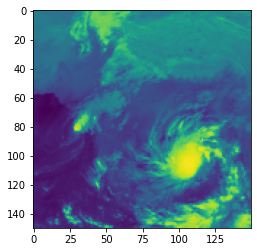

In [3]:
import os
images = []
# Load in the images
for filepath in os.listdir('drive/My Drive/INSAT3D_TIR1_PNG'):
    img = cv.imread('drive/My Drive/INSAT3D_TIR1_PNG/{0}'.format(filepath),0)
    images.append(cv.resize(img,(150,150),interpolation=cv.INTER_AREA))
first_frame = images[0]
print(first_frame.shape)
plt.imshow(first_frame)

### **Hyperparameter 1: Tuning the MaxPool Size**

---
Monitor performance over the following MaxPool sizes:
- (2,2)
- (3,3)
- (4,4)

---
Results: ***Best output produced with MaxPool set to 4***


In [4]:
maxpool_val_history = {}
maxpool_train_history = {}

In [5]:
for i in range(2,5):
  print("Training with pool size: " + str(i))
  model = Sequential()
  model.add(BatchNormalization(input_shape=(4,150,150,1)))

  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(i,i))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(i,i))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(i,i))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units=512, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
  model.add(LSTM(units=512, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))
  model.add(Dense(22500))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(np.asarray(images[0:4]).reshape(1,4,150,150,1), np.asarray(images[4]).reshape(1,22500),
          validation_data = (np.asarray(images[4:8]).reshape(1,4,150,150,1), np.asarray(images[8]).reshape(1,22500)),
          batch_size=4, epochs=50, verbose=0)
  
  maxpool_train_history["MaxPool " + str(i)] = model.history.history['loss']
  maxpool_val_history["MaxPool " + str(i)] = model.history.history['val_loss']

Training with pool size: 2
Training with pool size: 3
Training with pool size: 4


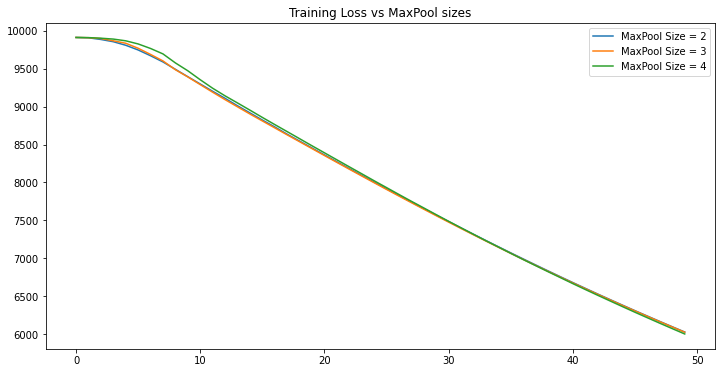

In [10]:
plt.figure(figsize=(12,6))
plt.title("Training Loss vs MaxPool sizes")

plt.plot(maxpool_train_history["MaxPool 2"], label="MaxPool Size = 2")
plt.plot(maxpool_train_history["MaxPool 3"], label="MaxPool Size = 3")
plt.plot(maxpool_train_history["MaxPool 4"], label="MaxPool Size = 4")
plt.legend()

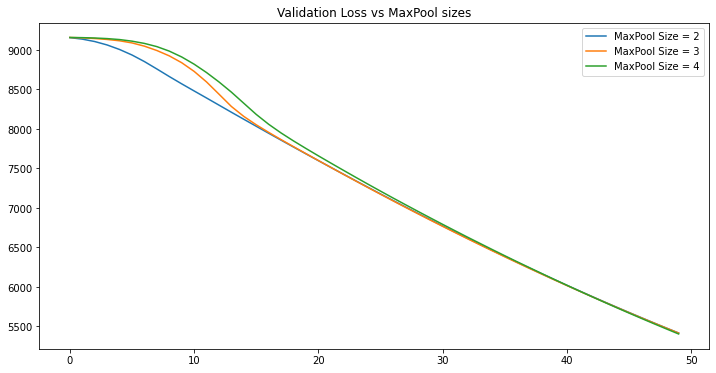

In [11]:
plt.figure(figsize=(12,6))
plt.title("Validation Loss vs MaxPool sizes")

plt.plot(maxpool_val_history["MaxPool 2"], label="MaxPool Size = 2")
plt.plot(maxpool_val_history["MaxPool 3"], label="MaxPool Size = 3")
plt.plot(maxpool_val_history["MaxPool 4"], label="MaxPool Size = 4")
plt.legend()

In [14]:
pd.DataFrame(
    {
        "train": {
          "MaxPool 2": maxpool_train_history["MaxPool 2"][-1],
          "MaxPool 3": maxpool_train_history["MaxPool 3"][-1],
          "MaxPool 4": maxpool_train_history["MaxPool 4"][-1]
        },
        "validation": {
          "MaxPool 2": maxpool_val_history["MaxPool 2"][-1],
          "MaxPool 3": maxpool_val_history["MaxPool 3"][-1],
          "MaxPool 4": maxpool_val_history["MaxPool 4"][-1]
        }
    }
).head()

,train,validation
MaxPool 2,6030.954590,5417.141113
MaxPool 3,6028.863770,5416.191895
MaxPool 4,6005.385742,5404.803711


### **Hyperparameter 2: Dropout Probability**

---
Monitor performance over the following dropouts:
- 0.0
- 0.2
- 0.4
- 0.6

---
Results: ***Best output produced with Dropout = 0.4***

In [15]:
val_history = {}
train_history = {}

In [17]:
i = 0.0
while i < 0.8:
  model = Sequential()
  model.add(BatchNormalization(input_shape=(4,150,150,1)))

  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(i)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(i)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(i)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units=512, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
  model.add(LSTM(units=512, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))
  model.add(Dense(22500))

  model.compile(loss='mean_squared_error', optimizer='adam')
  print("Dropout " + str(i) + "...Now Training =>")
  model.fit(np.asarray(images[0:4]).reshape(1,4,150,150,1), np.asarray(images[4]).reshape(1,22500),
          validation_data = (np.asarray(images[4:8]).reshape(1,4,150,150,1), np.asarray(images[8]).reshape(1,22500)),
          batch_size=4, epochs=50, verbose=0)
  
  train_history["Dropout " + str(i)] = model.history.history['loss']
  val_history["Dropout " + str(i)] = model.history.history['val_loss']
  print("Dropout " + str(i) + "...Done")
  i = i+0.2

Dropout 0.0...Now Training =>
Dropout 0.0...Done
Dropout 0.2...Now Training =>
Dropout 0.2...Done
Dropout 0.4...Now Training =>
Dropout 0.4...Done
Dropout 0.6000000000000001...Now Training =>
Dropout 0.6000000000000001...Done


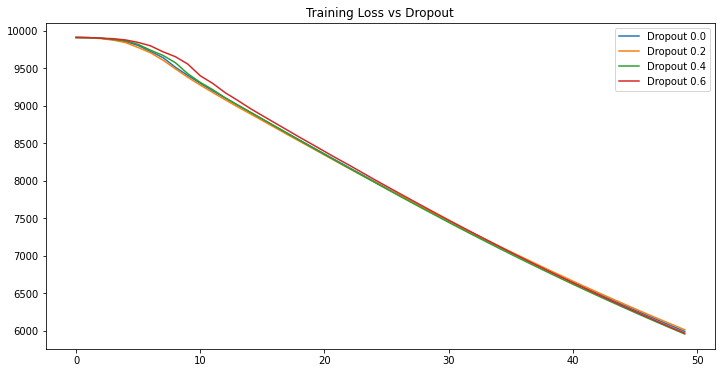

In [19]:
plt.figure(figsize=(12,6))
plt.title("Training Loss vs Dropout")

plt.plot(train_history["Dropout 0.0"], label="Dropout 0.0")
plt.plot(train_history["Dropout 0.2"], label="Dropout 0.2")
plt.plot(train_history["Dropout 0.4"], label="Dropout 0.4")
plt.plot(train_history["Dropout 0.6000000000000001"], label="Dropout 0.6")
plt.legend()

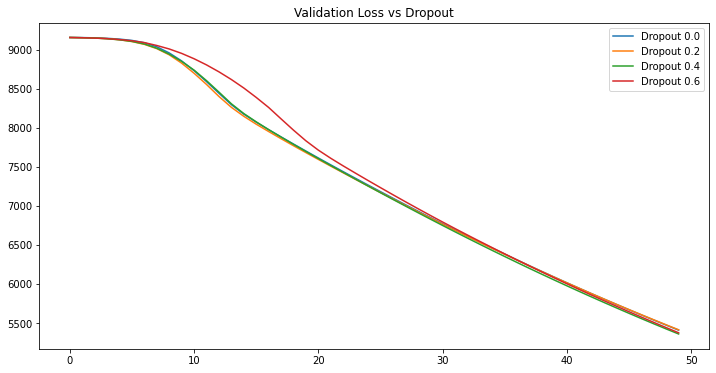

In [20]:
plt.figure(figsize=(12,6))
plt.title("Validation Loss vs Dropout")

plt.plot(val_history["Dropout 0.0"], label="Dropout 0.0")
plt.plot(val_history["Dropout 0.2"], label="Dropout 0.2")
plt.plot(val_history["Dropout 0.4"], label="Dropout 0.4")
plt.plot(val_history["Dropout 0.6000000000000001"], label="Dropout 0.6")
plt.legend()

In [22]:
pd.DataFrame(
    {
        "train": {
          "Dropout 0.0": train_history["Dropout 0.0"][-1],
          "Dropout 0.2": train_history["Dropout 0.2"][-1],
          "Dropout 0.4": train_history["Dropout 0.4"][-1],
          "Dropout 0.6": train_history["Dropout 0.6000000000000001"][-1]
        },
        "validation": {
          "Dropout 0.0": val_history["Dropout 0.0"][-1],
          "Dropout 0.2": val_history["Dropout 0.2"][-1],
          "Dropout 0.4": val_history["Dropout 0.4"][-1],
          "Dropout 0.6": val_history["Dropout 0.6000000000000001"][-1]
        }
    }
).head()

,train,validation
Dropout 0.0,5992.740234,5407.990723
Dropout 0.2,6014.241211,5412.196289
Dropout 0.4,5958.676270,5358.645996
Dropout 0.6,5969.801270,5373.860352


### **Hyperparameter 3: Number of LSTM units**

---
Monitor performance over the following LSTM units:
- 128
- 256
- 512
- 1024

---
Results: ***Best output produced with LSTM num_units = 1024***

In [23]:
val_history = {}
train_history = {}

In [24]:
i = 128
while i <= 1024:
  model = Sequential()
  model.add(BatchNormalization(input_shape=(4,150,150,1)))

  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units=i, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
  model.add(LSTM(units=i, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))
  model.add(Dense(22500))

  model.compile(loss='mean_squared_error', optimizer='adam')
  print("LSTM Units " + str(i) + "...Now Training =>")
  model.fit(np.asarray(images[0:4]).reshape(1,4,150,150,1), np.asarray(images[4]).reshape(1,22500),
          validation_data = (np.asarray(images[4:8]).reshape(1,4,150,150,1), np.asarray(images[8]).reshape(1,22500)),
          batch_size=4, epochs=50, verbose=0)
  
  train_history["LSTM " + str(i)] = model.history.history['loss']
  val_history["LSTM " + str(i)] = model.history.history['val_loss']
  print("LSTM Units " + str(i) + "...Done")
  i = i*2

LSTM Units 128...Now Training =>
LSTM Units 128...Done
LSTM Units 256...Now Training =>
LSTM Units 256...Done
LSTM Units 512...Now Training =>
LSTM Units 512...Done
LSTM Units 1024...Now Training =>
LSTM Units 1024...Done


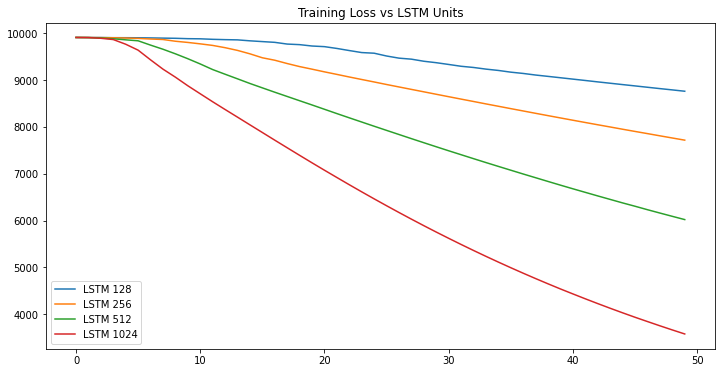

In [25]:
plt.figure(figsize=(12,6))
plt.title("Training Loss vs LSTM Units")

plt.plot(train_history["LSTM 128"], label="LSTM 128")
plt.plot(train_history["LSTM 256"], label="LSTM 256")
plt.plot(train_history["LSTM 512"], label="LSTM 512")
plt.plot(train_history["LSTM 1024"], label="LSTM 1024")
plt.legend()

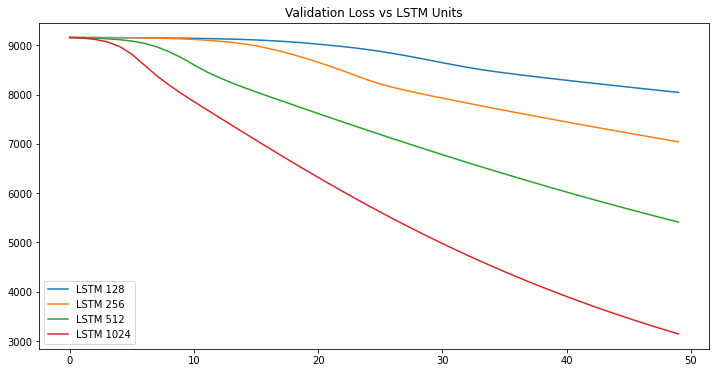

In [26]:
plt.figure(figsize=(12,6))
plt.title("Validation Loss vs LSTM Units")

plt.plot(val_history["LSTM 128"], label="LSTM 128")
plt.plot(val_history["LSTM 256"], label="LSTM 256")
plt.plot(val_history["LSTM 512"], label="LSTM 512")
plt.plot(val_history["LSTM 1024"], label="LSTM 1024")
plt.legend()

In [27]:
pd.DataFrame(
    {
        "train": {
          "LSTM 128": train_history["LSTM 128"][-1],
          "LSTM 256": train_history["LSTM 256"][-1],
          "LSTM 512": train_history["LSTM 512"][-1],
          "LSTM 1024": train_history["LSTM 1024"][-1]
        },
        "validation": {
          "LSTM 128": val_history["LSTM 128"][-1],
          "LSTM 256": val_history["LSTM 256"][-1],
          "LSTM 512": val_history["LSTM 512"][-1],
          "LSTM 1024": val_history["LSTM 1024"][-1]
        }
    }
).head()

,train,validation
LSTM 128,8761.062500,8045.075684
LSTM 256,7716.565918,7042.070801
LSTM 512,6020.387695,5413.271973
LSTM 1024,3577.994629,3143.653076


### **Hyperparameter 4: Output Layer Activation**

---
Monitor performance over the following activations:
- none
- relu
- softplus

---
Results: ***Best output produced with Dense activation = Softplus***

In [28]:
val_history = {}
train_history = {}

In [29]:
i = 0
while i < 3:
  model = Sequential()
  model.add(BatchNormalization(input_shape=(4,150,150,1)))

  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units=1024, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
  model.add(LSTM(units=1024, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))
  if i == 0:
    model.add(Dense(22500))  
  elif i == 1:
    model.add(Dense(22500, activation='relu'))
  elif i == 2:
    model.add(Dense(22500, activation='softplus'))

  model.compile(loss='mean_squared_error', optimizer='adam')
  model.fit(np.asarray(images[0:4]).reshape(1,4,150,150,1), np.asarray(images[4]).reshape(1,22500),
          validation_data = (np.asarray(images[4:8]).reshape(1,4,150,150,1), np.asarray(images[8]).reshape(1,22500)),
          batch_size=4, epochs=50, verbose=0)
  
  if i == 0:
    train_history["Activation None"] = model.history.history['loss']
    val_history["Activation None"] = model.history.history['val_loss']  
  elif i == 1:
    train_history["Activation Relu"] = model.history.history['loss']
    val_history["Activation Relu"] = model.history.history['val_loss']
  elif i == 2:
    train_history["Activation Softplus"] = model.history.history['loss']
    val_history["Activation Softplus"] = model.history.history['val_loss']
  
  print("Iteration Done")
  i = i+1

Iteration Done
Iteration Done
Iteration Done


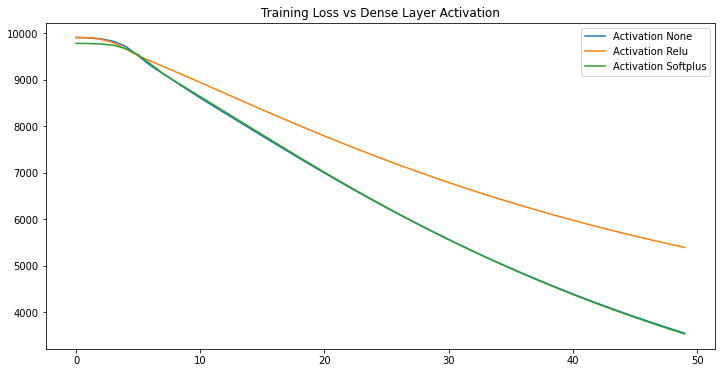

In [30]:
plt.figure(figsize=(12,6))
plt.title("Training Loss vs Dense Layer Activation")

plt.plot(train_history["Activation None"], label="Activation None")
plt.plot(train_history["Activation Relu"], label="Activation Relu")
plt.plot(train_history["Activation Softplus"], label="Activation Softplus")
plt.legend()

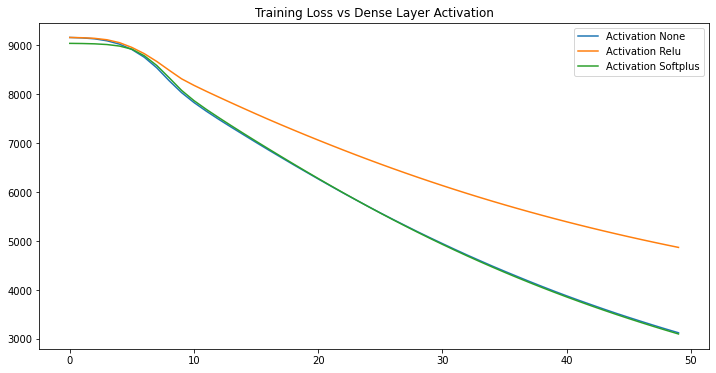

In [31]:
plt.figure(figsize=(12,6))
plt.title("Training Loss vs Dense Layer Activation")

plt.plot(val_history["Activation None"], label="Activation None")
plt.plot(val_history["Activation Relu"], label="Activation Relu")
plt.plot(val_history["Activation Softplus"], label="Activation Softplus")
plt.legend()

In [32]:
pd.DataFrame(
    {
        "train": {
          "Activation None": train_history["Activation None"][-1],
          "Activation Relu": train_history["Activation Relu"][-1],
          "Activation Softplus": train_history["Activation Softplus"][-1],
        },
        "validation": {
          "Activation None": val_history["Activation None"][-1],
          "Activation Relu": val_history["Activation Relu"][-1],
          "Activation Softplus": val_history["Activation Softplus"][-1],
        }
    }
).head()

,train,validation
Activation None,3547.618164,3125.468506
Activation Relu,5392.146973,4869.210449
Activation Softplus,3531.008057,3100.809570


### **Hyperparameter 5: Model Optimizer**

---
Monitor performance over the following optimizers:
- sgd
- rmsprop
- adam
- nadam
- adamax

---
Results: ***Best output produced with optimizer = nadam***

In [33]:
val_history = {}
train_history = {}

In [34]:
optimizers = ["sgd","rmsprop","adam","nadam","adamax"]
for i in range(len(optimizers)):
  model = Sequential()
  model.add(BatchNormalization(input_shape=(4,150,150,1)))

  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units=1024, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
  model.add(LSTM(units=1024, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))
  model.add(Dense(22500, activation='softplus'))

  model.compile(loss='mean_squared_error', optimizer=optimizers[i])
  print("Fitting with optimizer: " + optimizers[i])
  model.fit(np.asarray(images[0:4]).reshape(1,4,150,150,1), np.asarray(images[4]).reshape(1,22500),
          validation_data = (np.asarray(images[4:8]).reshape(1,4,150,150,1), np.asarray(images[8]).reshape(1,22500)),
          batch_size=4, epochs=50, verbose=0)
  
  train_history["Optimizer " + optimizers[i]] = model.history.history['loss']
  val_history["Optimizer " + optimizers[i]] = model.history.history['val_loss']
  print("DONE!")

Fitting with optimizer: sgd
DONE!
Fitting with optimizer: rmsprop
DONE!
Fitting with optimizer: adam
DONE!
Fitting with optimizer: nadam
DONE!
Fitting with optimizer: adamax
DONE!


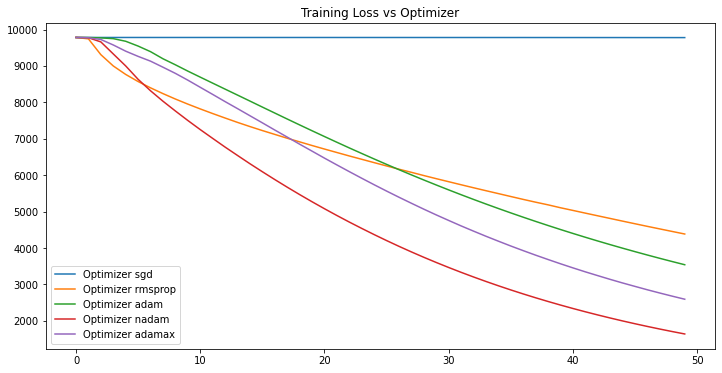

In [36]:
plt.figure(figsize=(12,6))
plt.title("Training Loss vs Optimizer")

for i in range(len(optimizers)):
  plt.plot(train_history["Optimizer " + optimizers[i]], label="Optimizer " + optimizers[i])
plt.legend()

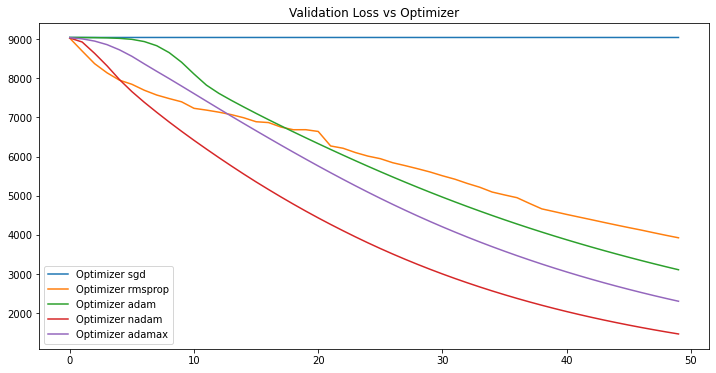

In [37]:
plt.figure(figsize=(12,6))
plt.title("Validation Loss vs Optimizer")

for i in range(len(optimizers)):
  plt.plot(val_history["Optimizer " + optimizers[i]], label="Optimizer " + optimizers[i])
plt.legend()

In [38]:
pd.DataFrame(
    {
        "train": {
          "Optimizer sgd": train_history["Optimizer sgd"][-1],
          "Optimizer rmsprop": train_history["Optimizer rmsprop"][-1],
          "Optimizer adam": train_history["Optimizer adam"][-1],
          "Optimizer nadam": train_history["Optimizer nadam"][-1],
          "Optimizer adamax": train_history["Optimizer adamax"][-1]
        },
        "validation": {
          "Optimizer sgd": val_history["Optimizer sgd"][-1],
          "Optimizer rmsprop": val_history["Optimizer rmsprop"][-1],
          "Optimizer adam": val_history["Optimizer adam"][-1],
          "Optimizer nadam": val_history["Optimizer nadam"][-1],
          "Optimizer adamax": val_history["Optimizer adamax"][-1]
        }
    }
).head()

,train,validation
Optimizer sgd,9778.237305,9038.084961
Optimizer rmsprop,4383.940430,3925.267090
Optimizer adam,3540.413818,3109.673340
Optimizer nadam,1638.900269,1470.260498
Optimizer adamax,2593.413574,2305.605225


### **Hyperparameter 6: Number of epochs**

---
Monitor performance over the following number of epochs:
- 50
- 75
- 100
- 125
- 150

---
Results: ***Best output produced with n_epochs = ***

In [4]:
val_history = {}
train_history = {}

In [5]:
i = 50
while i <= 150:
  model = Sequential()
  model.add(BatchNormalization(input_shape=(4,150,150,1)))

  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
  model.add(TimeDistributed(BatchNormalization()))
  model.add(TimeDistributed(MaxPooling2D(pool_size=(4,4))))
  model.add(TimeDistributed(Dropout(0.4)))

  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units=1024, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
  model.add(LSTM(units=1024, activation='tanh', recurrent_activation='hard_sigmoid', kernel_initializer='glorot_uniform', unit_forget_bias=True, dropout=0.3, recurrent_dropout=0.3, return_sequences=False))
  model.add(Dense(22500, activation='softplus'))

  model.compile(loss='mean_squared_error', optimizer='nadam')
  print("Fitting with epochs: " + str(i))
  model.fit(np.asarray(images[0:4]).reshape(1,4,150,150,1), np.asarray(images[4]).reshape(1,22500),
          validation_data = (np.asarray(images[4:8]).reshape(1,4,150,150,1), np.asarray(images[8]).reshape(1,22500)),
          batch_size=4, epochs=i, verbose=0)
  
  train_history["Epochs " + str(i)] = model.history.history['loss']
  val_history["Epochs " + str(i)] = model.history.history['val_loss']
  print("DONE!")
  i = i+25

Fitting with epochs: 50
DONE!
Fitting with epochs: 75
DONE!
Fitting with epochs: 100
DONE!
Fitting with epochs: 125
DONE!
Fitting with epochs: 150
DONE!


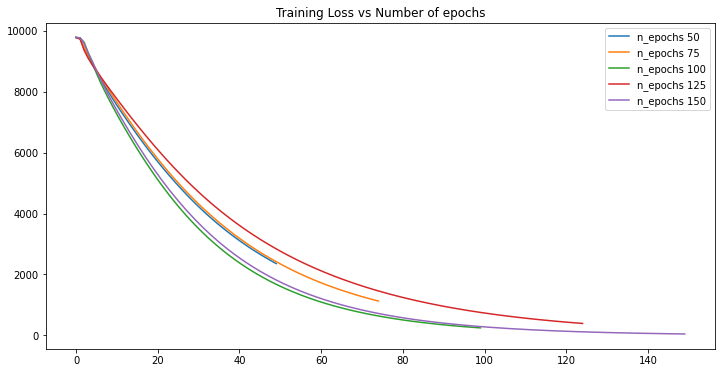

In [6]:
plt.figure(figsize=(12,6))
plt.title("Training Loss vs Number of epochs")

for i in range(50,175,25):
  plt.plot(train_history["Epochs " + str(i)], label="n_epochs " + str(i))
plt.legend()

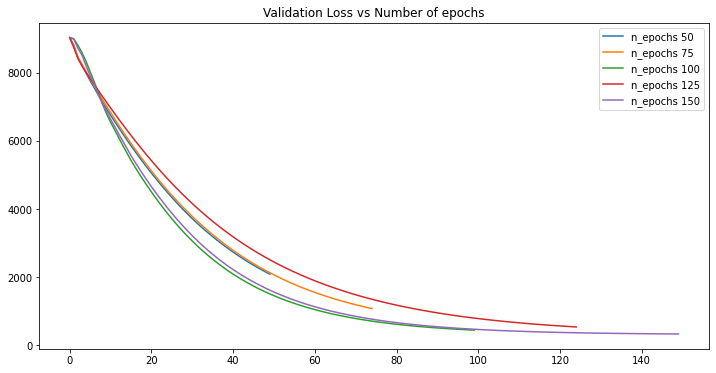

In [7]:
plt.figure(figsize=(12,6))
plt.title("Validation Loss vs Number of epochs")

for i in range(50,175,25):
  plt.plot(val_history["Epochs " + str(i)], label="n_epochs " + str(i))
plt.legend()

In [8]:
pd.DataFrame(
    {
        "train": {
          "Epochs 50": train_history["Epochs 50"][-1],
          "Epochs 75": train_history["Epochs 75"][-1],
          "Epochs 100": train_history["Epochs 100"][-1],
          "Epochs 125": train_history["Epochs 125"][-1],
          "Epochs 150": train_history["Epochs 150"][-1]
        },
        "validation": {
          "Epochs 50": val_history["Epochs 50"][-1],
          "Epochs 75": val_history["Epochs 75"][-1],
          "Epochs 100": val_history["Epochs 100"][-1],
          "Epochs 125": val_history["Epochs 125"][-1],
          "Epochs 150": val_history["Epochs 150"][-1]
        }
    }
).head()

,train,validation
Epochs 50,2356.236328,2088.512695
Epochs 75,1127.275024,1079.228516
Epochs 100,245.330978,447.489746
Epochs 125,391.028931,540.923340
Epochs 150,45.069534,334.762787
